## Load Modules to Check Environment

In [1]:
import platform, sys, os

In [2]:
# use default GMTSAR installation path
PATH = os.environ['PATH']
if PATH.find('GMTSAR') == -1:
    PATH = os.environ['PATH'] + ':/usr/local/GMTSAR/bin/'
    %env PATH {PATH}

## Load and Setup Python Modules

In [3]:
import xarray as xr
import numpy as np
import pandas as pd
# supress numpy warnings
import warnings
warnings.filterwarnings('ignore')
from dask.distributed import Client

In [4]:
# plotting modules
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [5]:
from pygmtsar import SBAS

## Define Parameters

In [6]:
MASTER       = '2015-04-03'
WORKDIR      = 'raw_stack'
DATADIR      = 'raw_orig'
#DEMFILE      = 'topo/dem.grd'
DEMFILE      = None
BASEDAYS     = 100
BASEMETERS   = 150
DEFOMAX      = 0

## Run Local Dask Cluster

Launch Dask cluster for local and distributed multicore computing. That's possible to process terabyte scale Sentinel-1 SLC datasets on Apple Air 16 GB RAM.

In [126]:
#import dask
#dask.config.set({'debug': {'scheduler': 'False', 'worker': 'False'}})

if 'client' in globals():
    client.close()
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53107,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:53119,Total threads: 2
Dashboard: http://127.0.0.1:53122/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:53110,


## Init SBAS

Search recursively for measurement (.tiff) and annotation (.xml) and orbit (.EOF) files in the DATA directory. It can be directory with full unzipped scenes (.SAFE) subdirectories or just a directory with the list of pairs of required .tiff and .xml files (maybe pre-filtered for orbit, polarization and subswath to save disk space). If orbit files and DEM are missed these will be downloaded automatically below.

In [8]:
# use DEM from the example
sbas = SBAS(DATADIR, DEMFILE, WORKDIR).set_master(MASTER)
sbas.to_dataframe()

,datetime,orbit,mission,polarization,subswath,datapath,metapath,orbitpath,geometry
date,,,,,,,,,
2015-01-21,2015-01-21 13:44:13,D,S1A,VV,1,raw_orig/s1a-iw1-slc-vv-20150121t134413-201501...,raw_orig/s1a-iw1-slc-vv-20150121t134413-201501...,raw_orig/S1A_OPER_AUX_POEORB_OPOD_20150211T122...,"POLYGON ((-114.75426 31.90914, -114.64120 32.6..."
2015-03-10,2015-03-10 13:44:12,D,S1A,VV,1,raw_orig/s1a-iw1-slc-vv-20150310t134412-201503...,raw_orig/s1a-iw1-slc-vv-20150310t134412-201503...,raw_orig/S1A_OPER_AUX_POEORB_OPOD_20150331T123...,"POLYGON ((-114.75400 31.90946, -114.64089 32.6..."
2015-04-03,2015-04-03 13:44:13,D,S1A,VV,1,raw_orig/s1a-iw1-slc-vv-20150403t134413-201504...,raw_orig/s1a-iw1-slc-vv-20150403t134413-201504...,raw_orig/S1A_OPER_AUX_POEORB_OPOD_20150424T123...,"POLYGON ((-114.75358 31.91797, -114.64322 32.6..."
2015-04-27,2015-04-27 13:44:14,D,S1A,VV,1,raw_orig/s1a-iw1-slc-vv-20150427t134414-201504...,raw_orig/s1a-iw1-slc-vv-20150427t134414-201504...,raw_orig/S1A_OPER_AUX_POEORB_OPOD_20150518T122...,"POLYGON ((-114.75346 31.91668, -114.64307 32.6..."
2015-05-21,2015-05-21 13:44:15,D,S1A,VV,1,raw_orig/s1a-iw1-slc-vv-20150521t134415-201505...,raw_orig/s1a-iw1-slc-vv-20150521t134415-201505...,raw_orig/S1A_OPER_AUX_POEORB_OPOD_20150611T122...,"POLYGON ((-114.75262 31.91668, -114.64223 32.6..."


### Download SRTM DEM

The function below downloads SRTM1 or SRTM3 DEM and converts heights to ellipsoidal model using EGM96 grid.
Besides, for faster processing we can use pre-defined DEM file as explained above.

SRTM1 product is 30m resolution DEM and SRTM3 is 90m. SRTM1 is much bigger (~10 times) and is usable for small areas. Mainly 90m SRTM3 is the right choice. Use parameter resolution_meters (60 meters by default) to interpolate the DEM to required resolution for the future processing and output.

The DEM grid is NetCDF file.

In [9]:
# buffer required to get correct (binary) results from SAT_llt2rat tool
# small margin produces insufficient DEM not covers the defined area
# https://docs.generic-mapping-tools.org/6.0/datasets/earth_relief.html
# only bicubic interpolation supported as the best one for the case
def download_dem(self, backend=None, product='SRTM1', resolution_meters=None, method=None, buffer_degrees=0.02, debug=False):
    """
    Download and preprocess digital elevation model (DEM) data.

    Parameters
    ----------
    backend : None, optional
        Deprecated argument. Ignored.
    product : str, optional
        Product type of the DEM data. Available options are 'SRTM1' (default) and 'SRTM3'.
    resolution_meters : int, optional
        Approximate desired resolution of the DEM data in meters. Default is 60 meters.
    method : None, optional
        Deprecated argument. Ignored.
    buffer_degrees : float, optional
        Buffer size in degrees to expand the area covered by the DEM. Default is 0.02 degrees.
    debug : bool, optional
        Enable debug mode. Default is False.

    Returns
    -------
    None

    Examples
    --------
    Download STRM1 DEM with a resolution of 30 meters and convert it to the default 60-meter grid:
    sbas.download_dem()

    Download STRM1 DEM with a resolution of 30 meters and convert it to a 60-meter grid:
    sbas.download_dem(resolution_meters=60)

    Download STRM3 DEM with a resolution of 90 meters and convert it to a 120-meter grid:
    sbas.download_dem(product='STRM3', resolution_meters=120)

    Notes
    -----
    This method uses the GMT servers to download SRTM 1 or 3 arc-second DEM data. The downloaded data is then preprocessed
    by removing the EGM96 geoid to make the heights relative to the WGS84 ellipsoid. The DEM is regridded to the specified
    approximate resolution using bicubic interpolation.
    """
    import xarray as xr
    import numpy as np
    import pygmt
    import os
    #import subprocess
    from tqdm.auto import tqdm

    if self.dem_filename is not None:
        print ('NOTE: DEM exists, ignore the command. Use SBAS.set_dem(None) to allow new DEM downloading')
        return

    if backend is not None:
        print ('Note: "backend" argument is deprecated, just omit it')
    if method is not None:
        print ('Note: "method" argument is deprecated, just omit it')
    if resolution_meters is not None:
        print ('Note: "resolution_meters" argument is deprecated, just omit it')

    if product == 'SRTM1':
        resolution = '01s'
    elif product == 'SRTM3':
        resolution = '03s'
    elif product in ['01s', '03s']:
        resolution = product
    else:
        print (f'ERROR: unknown product {product}. Available only SRTM1 ("01s") and SRTM3 ("03s") DEM using GMT servers')

    err, warn = self.validate()
    #print ('err, warn', err, warn)
    assert not err and not warn, 'ERROR: Please fix all the issues listed above to continue'

    # generate DEM for the area using GMT extent as W E S N
    # round the coordinates up to 1 mm
    minx, miny, maxx, maxy = self.df.dissolve().envelope.buffer(buffer_degrees).bounds.round(8).values[0]
    # Set the region for the grdcut and grdsample operations
    region = [minx, maxx, miny, maxy]

    gmtsar_sharedir = PRM().gmtsar_sharedir()
    geoid_filename = os.path.join(gmtsar_sharedir, 'geoid_egm96_icgem.grd')
    dem_filename = os.path.join(self.basedir, 'DEM_WGS84.nc')

    with tqdm(desc='DEM Downloading', total=1) as pbar:
        ortho = pygmt.datasets.load_earth_relief(resolution=resolution, region=region)
        #print ('ortho', ortho)
        geoid = xr.open_dataarray(geoid_filename).rename({'y': 'lat', 'x': 'lon'}).interp_like(ortho, method='cubic')
        #print ('geoid', geoid)
        if os.path.exists(dem_filename):
            os.remove(dem_filename)
        #print ('(ortho + geoid_resamp)', (ortho + geoid))
        (ortho + geoid).rename('dem').to_netcdf(dem_filename)
        pbar.update(1)

    self.dem_filename = dem_filename

from pygmtsar import PRM
SBAS.download_dem = download_dem
sbas.set_dem(None)
sbas.download_dem()

DEM Downloading:   0%|          | 0/1 [00:00<?, ?it/s]

grdcut [WARNING]: (w - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: w reset from -115.76566527 to -115.765833333
grdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: e reset from -114.62089223 to -114.620833333
grdcut [WARNING]: (s - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: s reset from 31.8891395 to 31.8888888889
grdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: n reset from 32.7963035 to 32.7963888889


## Aligning

In [10]:
sbas.stack_parallel()

Reference:   0%|          | 0/1 [00:00<?, ?it/s]

Aligning:   0%|          | 0/4 [00:00<?, ?it/s]

## trans_dat

In [11]:
%%time

def trans_dat(self, subswath=None, coarsen=(2,2), chunksize=None, interactive=False):
    """
    Retrieve or calculate the transform data for a specific or all subswaths. This transform data is then saved as
    a NetCDF file for future use.

    This function generates data mapping from geographical coordinates to radar coordinates (azimuth-range domain).
    The function uses a Digital Elevation Model (DEM) to derive the geographical coordinates, and then uses the
    `SAT_llt2rat` function to map these to radar coordinates.

    Parameters
    ----------
    subswath : int, optional
        Subswath number to retrieve. If not specified, the function will retrieve the transform
        data for all available subswaths.

    interactive : bool, optional
        If True, the function returns the transform data without saving it. If False, the function
        saves the transform data as a NetCDF file. Default is False.

    Returns
    -------
    xarray.Dataset or dask.delayed.Delayed
        If interactive is True, it returns an xarray dataset with the transform data.
        If interactive is False, it returns a dask Delayed object representing the computation of writing
        the transform data to a NetCDF file.

    Examples
    --------
    Calculate and get the transform data for a specific subswath:
    >>> trans_dat(1)
    <dask.delayed.Delayed at 0x7f8d13a69a90>

    Calculate and get the transform data for all available subswaths:
    >>> trans_dat()
    <dask.delayed.Delayed at 0x7f8d13a69b70>

    Calculate and get the transform data without saving it:
    >>> trans_dat(interactive=True)
    """
    import dask
    import xarray as xr
    import numpy as np
    import os
    import sys
    
    # range, azimuth, elevation(ref to radius in PRM), lon, lat [ASCII default] 
    #llt2rat_map = {0: 'rng', 1: 'azi', 2: 'ele', 3: 'll', 4: 'lt'}
    # use only 3 values from 5 available ignoring redudant lat, lon
    llt2rat_map = {0: 'rng', 1: 'azi', 2: 'ele'}

    if chunksize is None:
        chunksize = self.chunksize
    
    # build trans.dat
    def SAT_llt2rat(z, lat, lon, subswath, amin=0, amax=None, rmin=0, rmax=None):
        if amax is not None and rmax is not None:
            # check border coordinates to detect if the block is completely outside of radar area
            lats = np.concatenate([lat, lat, np.repeat(lat[0], lon.size), np.repeat(lat[-1], lon.size)])
            lons = np.concatenate([np.repeat(lon[0], lat.size), np.repeat(lon[-1], lat.size), lon, lon])
            zs = np.concatenate([z[:,0], z[:,-1], z[0,:], z[-1,:]])
            coords_ll = np.column_stack([lons, lats, zs])
            # raell
            coords_ra = self.PRM(subswath).SAT_llt2rat(coords_ll, precise=1, binary=False)\
                .astype(np.float32).reshape(zs.size, 5)
            #print (coords_ra.shape)
            # check validity
            mask = (coords_ra[:,0]>=rmin) & (coords_ra[:,0]<=rmax) & (coords_ra[:,1]>=amin) & (coords_ra[:,1]<=amax)
            #print ('mask[mask].size', mask[mask].size)
            if mask[mask].size == 0:
                return np.nan * np.zeros((z.shape[0], z.shape[1], 5), np.float32)
        
        # compute 3D radar coordinates for all the geographical 3D points
        lons, lats = np.meshgrid(lon.astype(np.float32), lat.astype(np.float32))
        coords_ll = np.column_stack([lons.ravel(), lats.ravel(), z.ravel()])
        # for binary=True values outside of the scene missed and the array is not complete
        # 4th and 5th coordinates are the same as input lat, lon
        coords_ra = self.PRM(subswath).SAT_llt2rat(coords_ll, precise=1, binary=False)\
            .astype(np.float32).reshape(z.shape[0], z.shape[1], 5)[...,:3]
        if amax is not None and rmax is not None:
            # mask values outside of radar area
            mask = (coords_ra[...,0]>=rmin) & (coords_ra[...,0]<=rmax) & (coords_ra[...,1]>=amin) & (coords_ra[...,1]<=amax)
            coords_ra[~mask] = np.nan
        return coords_ra

    # exclude latitude and longitude columns as redudant
    def trans_block(lats, lons, subswath, amin=0, amax=None, rmin=0, rmax=None):
        dlat = dem.yy.diff('yy')[0]
        dlon = dem.xx.diff('xx')[0]
        topo = dem.sel(yy=slice(lats[0]-dlat, lats[-1]+dlat), xx=slice(lons[0]-dlon, lons[-1]+dlon))
        #print ('topo.shape', topo.shape, 'lats.size', lats.size, 'lons', lons.size)
        grid = topo.interp({topo.dims[0]: lats, topo.dims[1]: lons})
        #print ('grid.shape', grid.shape) 
        rae = SAT_llt2rat(grid.values, lats, lons, subswath, amin, amax, rmin, rmax)
        # cleanup to fix unmanaged memory increasing due to external obect use
        del topo, grid
        return rae

    # do not use coordinate names lat,lon because the output grid saved as (lon,lon) in this case...
    dem = self.get_dem(geoloc=True).rename({'lat': 'yy', 'lon': 'xx'})

    # check DEM corners
    dem_corners = dem[::dem.yy.size-1, ::dem.xx.size-1]
    rngs, azis, _ = trans_block(dem_corners.yy, dem_corners.xx, subswath).transpose(2,0,1)
    azi_size = abs(np.diff(azis, axis=0).mean())
    rng_size = abs(np.diff(rngs, axis=1).mean())
    #print ('azi_size', azi_size)
    #print ('rng_size', rng_size)
    azi_steps = int(np.round(azi_size / coarsen[0]))
    rng_steps = int(np.round(rng_size / coarsen[1]))
    #print ('azi_steps', azi_steps, 'rng_steps',rng_steps)
    
    # select radar coordinates extent
    rng_max, yvalid, num_patch = self.PRM(subswath).get('num_rng_bins', 'num_valid_az', 'num_patches')
    azi_max = yvalid * num_patch
    #print ('azi_max', azi_max, 'rng_max', rng_max)
    # allow 2 points around for linear and cubic interpolations
    extent= {'amin': -2*azi_size/azi_steps, 'amax': azi_max+2*azi_size/azi_steps,
             'rmin': -2*rng_size/rng_steps, 'rmax': rng_max+2*rng_size/rng_steps}
    #print ('extent', extent)
    
    ################################################################################
    # process the area
    ################################################################################
    lats = np.linspace(dem.yy[0], dem.yy[-1], azi_steps)
    lons = np.linspace(dem.xx[0], dem.xx[-1], rng_steps)
    #print ('lats', lats, 'lons', lons)
    #print ('lats.size', lats.size, 'lons.size', lons.size)
    #print ('lons', lons[0], lons[-1], lons[-10:])

    # split to equal chunks and rest
    lats_blocks = np.array_split(lats, np.arange(0,lats.size, chunksize)[1:])
    lons_blocks = np.array_split(lons, np.arange(0,lons.size, chunksize)[1:])
    #print ('lats_blocks.size', len(lats_blocks), 'lons_blocks.size', len(lons_blocks))
    #print ('lats_blocks[0]', lats_blocks[0])

#     # single block test
#     _ = trans_block(lats_blocks[0], lons_blocks[0], subswath, azi_max, rng_max)
#     print (_.shape)

    blocks_total = []
    for lons_block in lons_blocks:
        blocks = []
        for lats_block in lats_blocks:
            # extract multiple outputs
            #blockset = dask.delayed(trans_block)(...)
            #block = dask.array.from_delayed(blockset[0], shape=(...), dtype=np.float32)
            block = dask.array.from_delayed(dask.delayed(trans_block)(lats_block, lons_block, subswath, **extent),
                                            shape=(lats_block.size, lons_block.size, 3), dtype=np.float32)
            blocks.append(block.transpose(2,1,0))
        blocks_total.append(blocks)
    rae = dask.array.block(blocks_total).transpose(2,1,0)

    # transform to separate variables
    keys_vars = {val: xr.DataArray(rae[...,key], coords={'lat': lats,'lon': lons}) for (key, val) in llt2rat_map.items()}
    trans = xr.Dataset({**keys_vars})
    
    # calculate indices for topo_ra processing
    trans['azi_min'] = trans.azi.min('lon')
    trans['azi_max'] = trans.azi.max('lon')
    trans['rng_min'] = trans.rng.min('lat')
    trans['rng_max'] = trans.rng.max('lat')

    if interactive:
        return trans

    # save to NetCDF file
    filename = self.get_filenames(subswath, None, 'trans')
    if os.path.exists(filename):
        os.remove(filename)
    encoding = {val: self.compression(chunksize=chunksize) for (key, val) in llt2rat_map.items()}
    handler = trans.to_netcdf(filename,
                                    encoding=encoding,
                                    engine=self.engine,
                                    compute=False)
    return handler

import dask
from pygmtsar import tqdm_dask
SBAS.trans_dat = trans_dat
# #sbas.trans_dat_parallel()

# delayed = sbas.trans_dat(coarsen=(0.1, 2), interactive=True)
# delayed

# delayed = sbas.trans_dat(coarsen=(0.1, 2), chunksize=512*2, interactive=False)
# tqdm_dask(dask.persist(delayed))

# #delayed.plot.imshow()
# #sbas.trans_dat(interactive=True)

#sbas.trans_dat(coarsen=(0.5, 0.5))
#.compute()

#sbas.trans_dat(coarsen=(2,2)).compute()
# coarsen=(0.25, 1) blockcount 747.0 dem block 4.0 trans block 35.0 71% 56min
# coarsen=(0.1, 1) blockcount 1494.0 dem block 2.0 trans block 43.0 10% 11min
# coarsen=(0.1, 1) blockcount 2987 dem block 1.0 trans block 22.0 3% 14min
# ... blockcount 6003 dem block 0.0 trans block 11.0 3% 5:36
# ... blockcount 1493 dem block 2.0 trans block 43.0 RuntimeError('Requested dask.distributed scheduler but no Client active.')
# ... blockcount 1494.0 dem block 2.0 trans block 43.0 15% 30min WARNING - full garbage collections took 10% CPU time recently
# ... blockcount 2987.0 dem block 1.0 trans block 22.0

CPU times: user 14 µs, sys: 14 µs, total: 28 µs
Wall time: 29.1 µs


In [12]:
def trans_dat_parallel(self, interactive=False, **kwargs):
    """
    Retrieve or calculate the transform data for all subswaths in parallel. This function processes each subswath
    concurrently using Dask.

    Parameters
    ----------
    interactive : bool, optional
        If True, the function returns a list of dask.delayed.Delayed objects representing the computation of
        transform data for each subswath. If False, the function processes the transform data for each subswath
        concurrently using Dask. Default is False.

    Returns
    -------
    list or dask.delayed.Delayed
        If interactive is True, it returns a list of dask.delayed.Delayed objects representing the computation
        of transform data for each subswath.
        If interactive is False, it returns a dask.delayed.Delayed object representing the computation of
        transform data for all subswaths.

    Examples
    --------
    Calculate and get the transform data for all subswaths in parallel:

    >>> trans_dat_parallel()
    <dask.delayed.Delayed at 0x7f8d13a69a90>

    Calculate and get the transform data for all subswaths in parallel without saving it:

    >>> trans_dat_parallel(interactive=True)
    [<dask.delayed.Delayed at 0x7f8d13a69a90>, <dask.delayed.Delayed at 0x7f8d13a69b70>]
    """
    import dask

    # process all the subswaths
    subswaths = self.get_subswaths()
    delayeds = []
    for subswath in subswaths:
        delayed = self.trans_dat(subswath=subswath, interactive=interactive, **kwargs)
        if not interactive:
            tqdm_dask(dask.persist(delayed), desc=f'Radar Transform Computing sw{subswath}')
        else:
            delayeds.append(delayed)

    if interactive:
        return delayeds[0] if len(delayeds)==1 else delayeds

from pygmtsar import tqdm_dask
SBAS.trans_dat_parallel = trans_dat_parallel
# (2,2): 2:25 - 2:21 - 2:14
# (1,1): 9:10
# (0.25,0.25): ?
sbas.trans_dat_parallel(coarsen=(2, 2))
# 53:43 no indices
# ? indices

Radar Transform Computing sw1:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

In [13]:
def get_trans_dat(self, subswath=None):
    """
    Retrieve the transform data for a specific or all subswaths.

    This function opens a NetCDF dataset, which contains data mapping from geographical
    coordinates to radar coordinates (azimuth-range domain).

    Parameters
    ----------
    subswath : int, optional
        Subswath number to retrieve. If not specified, the function will retrieve the transform
        data for all available subswaths.

    Returns
    -------
    xarray.Dataset
        An xarray dataset with the transform data.

    Examples
    --------
    Get the transform data for a specific subswath:
    get_trans_dat(1)

    Get the transform data for all available subswaths:
    get_trans_dat()
    """
    import xarray as xr

    subswath = self.get_subswath(subswath)
    filename = self.get_filenames(subswath, None, 'trans')
    trans = xr.open_dataset(filename, engine=self.engine, chunks=self.chunksize)
    #.rename({'yy': 'lat', 'xx': 'lon'})
    return trans

SBAS.get_trans_dat = get_trans_dat
trans = sbas.get_trans_dat()
trans

<xarray.Dataset>
Dimensions:  (lat: 3470, lon: 12493)
Coordinates:
  * lat      (lat) float64 31.9 31.9 31.9 31.9 31.9 ... 32.79 32.79 32.79 32.79
  * lon      (lon) float64 -115.8 -115.8 -115.8 -115.8 ... -114.6 -114.6 -114.6
Data variables:
    azi      (lat, lon) float32 dask.array<chunksize=(512, 512), meta=np.ndarray>
    azi_max  (lat) float32 dask.array<chunksize=(512,), meta=np.ndarray>
    azi_min  (lat) float32 dask.array<chunksize=(512,), meta=np.ndarray>
    ele      (lat, lon) float32 dask.array<chunksize=(512, 512), meta=np.ndarray>
    rng      (lat, lon) float32 dask.array<chunksize=(512, 512), meta=np.ndarray>
    rng_max  (lon) float32 dask.array<chunksize=(512,), meta=np.ndarray>
    rng_min  (lon) float32 dask.array<chunksize=(512,), meta=np.ndarray>

### Use Indices

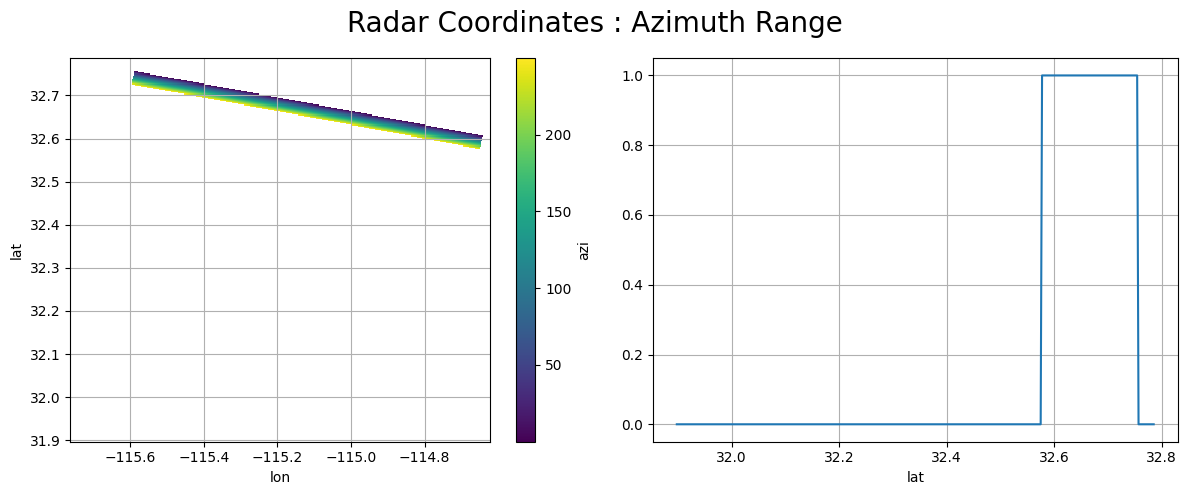

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

trans.azi.where((trans.azi>=0)&(trans.azi<=250))[::10,::10].plot.imshow(ax=axs[0])
axs[0].grid()

((trans.azi_min<=250)&(trans.azi_max>=0))[::10].plot(ax=axs[1])
axs[1].grid()

# Suptitle for the entire figure
fig.suptitle('Radar Coordinates : Azimuth Range', fontsize=20)
plt.tight_layout()
plt.show()

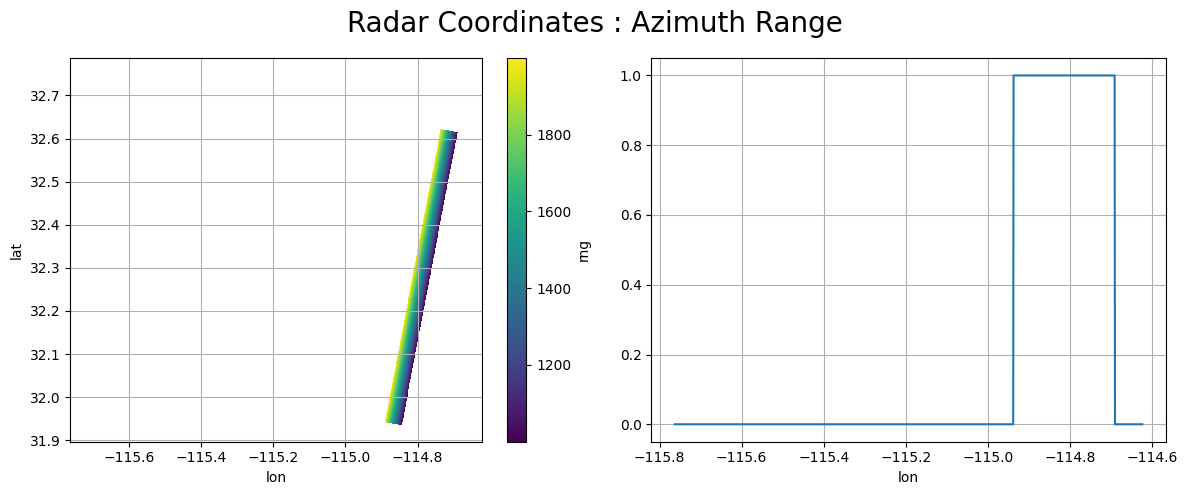

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

trans.rng.where((trans.rng>=1000)&(trans.rng<=2000))[::10,::10].plot.imshow(ax=axs[0])
axs[0].grid()

((trans.rng_min<=3000)&(trans.rng_max>=1000))[::10].plot(ax=axs[1])
axs[1].grid()

# Suptitle for the entire figure
fig.suptitle('Radar Coordinates : Azimuth Range', fontsize=20)
plt.tight_layout()
plt.show()

CPU times: user 81.2 ms, sys: 12.6 ms, total: 93.7 ms
Wall time: 173 ms


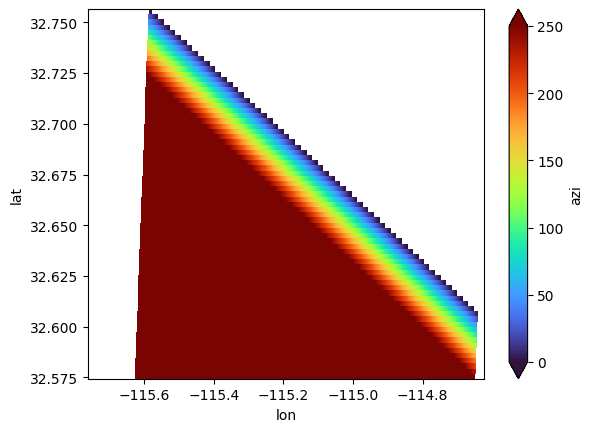

In [16]:
%%time
lats = trans.lat.where(((trans.azi_min<=250)&(trans.azi_max>=0)).compute(), drop=True)
#lons = trans.lon.where((trans.rng_min<=3000)&(trans.rng_max>=1000), drop=True)
trans.azi.sel(lat=lats)[::10,::10].plot.imshow(cmap='turbo', vmin=0, vmax=250)

CPU times: user 91.7 ms, sys: 14.1 ms, total: 106 ms
Wall time: 185 ms


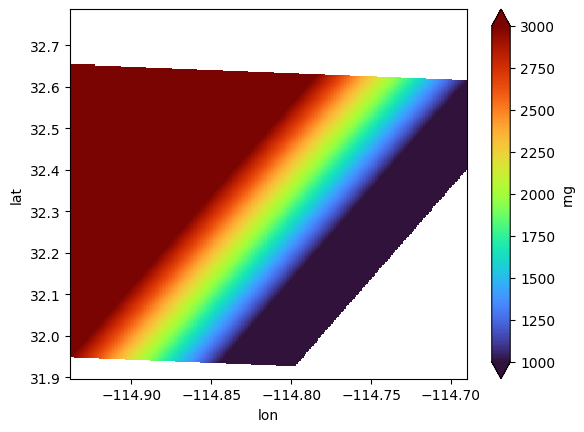

In [17]:
%%time
#lats = trans.lat.where((trans.azi_min<=250)&(trans.azi_max>=0), drop=True)
lons = trans.lon.where(((trans.rng_min<=3000)&(trans.rng_max>=1000)).compute(), drop=True)
trans.rng.sel(lon=lons)[::10,::10].plot.imshow(cmap='turbo', vmin=1000, vmax=3000)

CPU times: user 53.5 ms, sys: 9.58 ms, total: 63.1 ms
Wall time: 167 ms


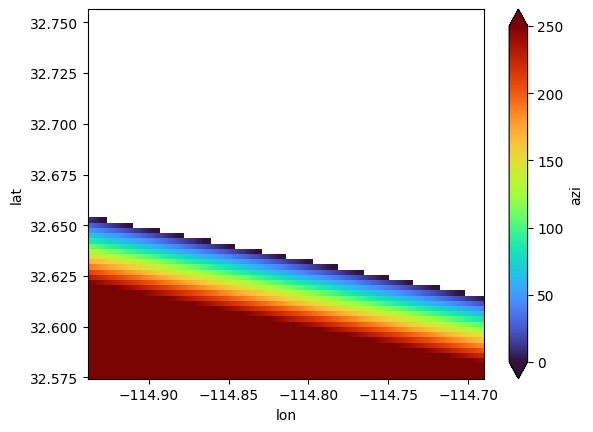

In [18]:
%%time
lats = trans.lat.where(((trans.azi_min<=250)&(trans.azi_max>=0)).compute(), drop=True)
lons = trans.lon.where(((trans.rng_min<=3000)&(trans.rng_max>=1000)).compute(), drop=True)
trans.azi.sel(lat=lats, lon=lons)[::10,::10].plot.imshow(cmap='turbo', vmin=0, vmax=250)

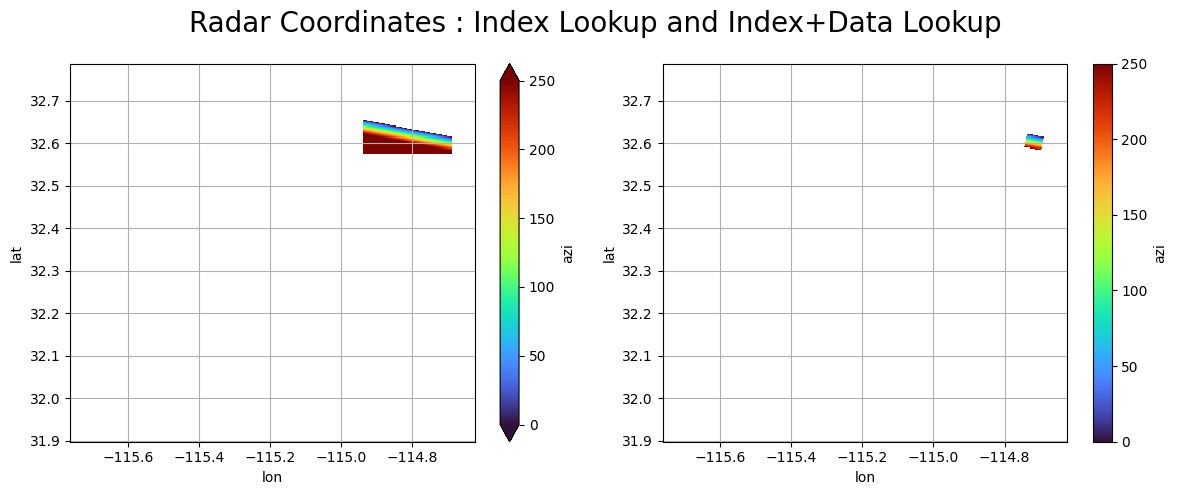

CPU times: user 315 ms, sys: 22 ms, total: 337 ms
Wall time: 558 ms


In [19]:
%%time
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

lats = trans.lat.where(((trans.azi_min<=250)&(trans.azi_max>=0)).compute(), drop=True)
lons = trans.lon.where(((trans.rng_min<=3000)&(trans.rng_max>=1000)).compute(), drop=True)
trans.azi.sel(lat=lats, lon=lons)\
    [::10,::10].plot.imshow(cmap='turbo', vmin=0, vmax=250, ax=axs[0])
axs[0].grid()

trans.azi.sel(lat=lats, lon=lons).where((trans.azi>=0)&(trans.azi<=250)&(trans.rng>=1000)&(trans.rng<=2000))\
    [::10,::10].plot.imshow(cmap='turbo', vmin=0, vmax=250, ax=axs[1])
axs[1].grid()

# Get the xlim and ylim of the second plot
xlim = (trans.lon.min(), trans.lon.max())
ylim = (trans.lat.min(), trans.lat.max())

# Set the xlim and ylim of the first plot to match the second
axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)

axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)

# Suptitle for the entire figure
fig.suptitle('Radar Coordinates : Index Lookup and Index+Data Lookup', fontsize=20)
plt.tight_layout()
plt.show()

## topo_ra tests

In [58]:
%%time

if 'trans' in globals():
    del trans

trans_dat = sbas.get_trans_dat()

trans_dat['azi_min'] = trans_dat.azi_min.compute()
trans_dat['azi_max'] = trans_dat.azi_max.compute()
trans_dat['rng_min'] = trans_dat.rng_min.compute()
trans_dat['rng_max'] = trans_dat.rng_max.compute()

CPU times: user 68.8 ms, sys: 21.2 ms, total: 90 ms
Wall time: 173 ms


In [63]:
%%time

def topo_ra_block_prepare(azis, rngs):
    dazi = np.diff(azis)[0]
    drng = np.diff(rngs)[0]
    azis_min = azis.min() - dazi
    azis_max = azis.max() + dazi
    rngs_min = rngs.min() - drng
    rngs_max = rngs.max() + drng
    print ('azis_min', azis_min, 'azis_max', azis_max)

    lats = trans_dat.lat[((trans_dat.azi_min<=azis_max)&(trans_dat.azi_max>=azis_min))]
    lons = trans_dat.lon[((trans_dat.rng_min<=rngs_max)&(trans_dat.rng_max>=rngs_min))]
    print ('lats.shape', lats.shape, 'lons.shape', lons.shape)

    # extract and materialize required subset
    trans_subset = trans_dat.sel(lat=lats, lon=lons)
    block_ele = trans_subset.ele.data.reshape(-1).compute(n_workers=1)
    block_azi = trans_subset.azi.data.reshape(-1).compute(n_workers=1)
    block_rng = trans_subset.rng.data.reshape(-1).compute(n_workers=1)
    mask = (block_azi>=azis_min)&(block_azi<=azis_max)&(block_rng>=rngs_min)&(block_rng<=rngs_max)
    block_ele = block_ele[mask]
    block_azi = block_azi[mask]
    block_rng = block_rng[mask]
    
    del trans_subset, mask
    return (block_azi, block_rng, block_ele)

data = topo_ra_block_prepare(np.arange(1024)[1::2], np.arange(1024)[1::2])
data

azis_min -1 azis_max 1025
lats.shape (1079,) lons.shape (2223,)
CPU times: user 132 ms, sys: 45.7 ms, total: 177 ms
Wall time: 484 ms


(array([ 1.0249891e+03,  1.0248727e+03,  1.0247576e+03, ...,
        -6.8267947e-01, -7.9735976e-01, -9.1335303e-01], dtype=float32),
 array([   9.8730955,    7.9027333,    5.9488826, ..., 1012.90985  ,
        1011.1724   , 1009.2366   ], dtype=float32),
 array([-283.91296, -283.62476, -283.3263 , ..., -346.53915, -346.86746,
        -346.71155], dtype=float32))

In [149]:
%%time
    
# for materialized indices
def topo_ra_block(data, azis, rngs):
    from scipy.spatial import cKDTree

    block_azi, block_rng, block_ele = data

    # interpolate topo_ra on trans_dat
    grid_azi, grid_rng = np.meshgrid(azis, rngs)
    tree = cKDTree(np.column_stack([block_azi, block_rng]), compact_nodes=False, balanced_tree=False)
    d, inds = tree.query(np.column_stack([grid_azi.ravel(), grid_rng.ravel()]), k = 1, workers=1)
    grid = block_ele[inds].reshape((rngs.size, azis.size)).T
    #print ('distance range', d.min().round(2), d.max().round(2))

    del block_ele, block_azi, block_rng, tree
    return grid

data = topo_ra_block_prepare(np.arange(1024)[1::2], np.arange(1024)[1::2])
topo = topo_ra_block(data, np.arange(1024)[1::2], np.arange(1024)[1::2])
topo

azis_min -1 azis_max 1025
lats.shape (1079,) lons.shape (2223,)
CPU times: user 285 ms, sys: 40.9 ms, total: 326 ms
Wall time: 630 ms


array([[-321.174  , -322.0898 , -323.00558, ..., -344.21045, -344.23874,
        -344.78986],
       [-320.4277 , -321.41318, -322.39865, ..., -345.075  , -345.07513,
        -345.0753 ],
       [-320.04037, -320.81747, -320.98926, ..., -345.91226, -345.07513,
        -345.0753 ],
       ...,
       [-284.18594, -284.2375 , -283.67178, ..., -288.11746, -288.2617 ,
        -288.5192 ],
       [-284.05933, -284.0797 , -284.1001 , ..., -288.8137 , -289.2612 ,
        -289.73996],
       [-282.48254, -282.80618, -283.10983, ..., -290.0903 , -290.508  ,
        -290.6491 ]], dtype=float32)

(512,) (256,)
azis_min 4497 azis_max 5525
lats.shape (1064,) lons.shape (2630,)
(256, 512)


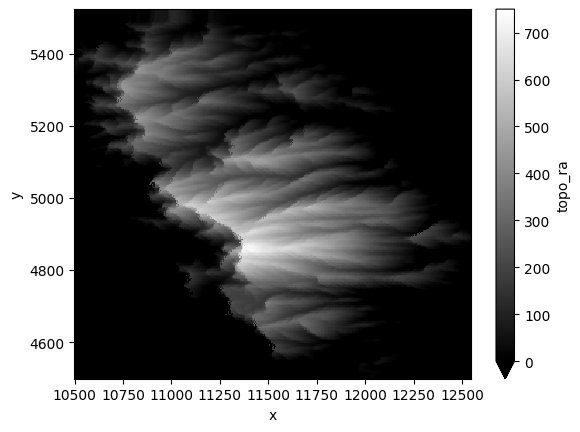

In [151]:
# compare to the full map
rngs = (10500 + np.arange(2048)[1::4])
azis = (4500  + np.arange(1024)[1::4])
print (rngs.shape, azis.shape)

data = topo_ra_block_prepare(azis, rngs)
topo = topo_ra_block(data, azis, rngs)
print (topo.shape)
topo = xr.DataArray(topo, coords={'y': azis, 'x': rngs}).rename('topo_ra')
topo.plot.imshow(cmap='gray', vmin=0, vmax=750)

(512,) (512,)
azis_min 4499 azis_max 5525
lats.shape (1063,) lons.shape (2630,)


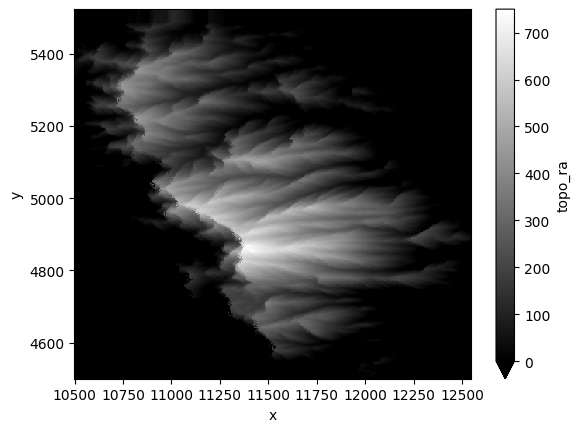

In [153]:
# compare to the full map
rngs = (10500 + np.arange(2048)[1::4])
azis = (4500  + np.arange(1024)[1::2])
print (rngs.shape, azis.shape)

data = topo_ra_block_prepare(azis, rngs)
topo = topo_ra_block(data, azis, rngs)
topo = xr.DataArray(topo, coords={'y': azis, 'x': rngs}).rename('topo_ra')
topo.plot.imshow(cmap='gray', vmin=0, vmax=750)
#topo

In [23]:
del trans_dat

## Topo_ra

In [154]:
def topo_ra(self, subswath=None, coarsen=(2,2), chunksize=None, interactive=False):
    """
    Compute the topography in radar coordinates (topo_ra).

    Parameters
    ----------
    subswath : int or None, optional
        The subswath number to compute the topographic radar coordinates for. If None, the computation
        will be performed for all subswaths. Default is None.
    idec : int, optional
        The decimation factor in the range direction. Default is 2.
    jdec : int, optional
        The decimation factor in the azimuth direction. Default is 2.
    n_jobs : int, optional
        The number of parallel jobs to run. Default is -1, which uses all available CPU cores.
    interactive : bool, optional
        If True, the computation will be performed interactively and the result will be returned as a delayed object.
        Default is False.

    Notes
    -----
    This method computes the topography in radar coordinates (topo_ra) for the specified subswath(s). It uses the trans.dat
    and trans_blocks_extents data files to build the necessary index tree and perform the coordinate transformation.
    The computed topo_ra grids are saved in NetCDF files and can be accessed using the 'get_topo_ra' method.
    """
    from scipy.spatial import cKDTree
    import dask
    import xarray as xr
    import numpy as np
    import os

    # for materialized indices
    @dask.delayed
    def topo_ra_block_prepare(azis, rngs):
        dazi = np.diff(azis)[0]
        drng = np.diff(rngs)[0]
        azis_min = azis.min() - dazi
        azis_max = azis.max() + dazi
        rngs_min = rngs.min() - drng
        rngs_max = rngs.max() + drng
        #print ('azis_min', azis_min, 'azis_max', azis_max)

        lats = trans_dat.lat[((trans_dat.azi_min<=azis_max)&(trans_dat.azi_max>=azis_min))]
        lons = trans_dat.lon[((trans_dat.rng_min<=rngs_max)&(trans_dat.rng_max>=rngs_min))]
        #print ('lats.shape', lats.shape, 'lons.shape', lons.shape)

        # extract and materialize required subset
        trans_subset = trans_dat.sel(lat=lats, lon=lons)
        block_ele = trans_subset.ele.data.reshape(-1).compute(n_workers=1)
        block_azi = trans_subset.azi.data.reshape(-1).compute(n_workers=1)
        block_rng = trans_subset.rng.data.reshape(-1).compute(n_workers=1)
        mask = (block_azi>=azis_min)&(block_azi<=azis_max)&(block_rng>=rngs_min)&(block_rng<=rngs_max)
        block_ele = block_ele[mask]
        block_azi = block_azi[mask]
        block_rng = block_rng[mask]

        del lats, lons, trans_subset, mask
        return (block_azi, block_rng, block_ele)

    @dask.delayed
    def topo_ra_block(data, azis, rngs):
        from scipy.spatial import cKDTree

        block_azi, block_rng, block_ele = data

        # interpolate topo_ra on trans_dat
        grid_azi, grid_rng = np.meshgrid(azis, rngs)
        tree = cKDTree(np.column_stack([block_azi, block_rng]), compact_nodes=False, balanced_tree=False)
        d, inds = tree.query(np.column_stack([grid_azi.ravel(), grid_rng.ravel()]), k = 1, workers=1)
        grid = block_ele[inds].reshape((rngs.size, azis.size)).T
        #print ('distance range', d.min().round(2), d.max().round(2))

        del block_ele, block_azi, block_rng, tree
        return grid

    
    if chunksize is None:
        chunksize = self.chunksize

    # trans.dat - file generated by llt_grid2rat (r a topo lon lat)"
    trans_dat = self.get_trans_dat(subswath)
    # materialize indices
    trans_dat['azi_min'] = trans_dat.azi_min.compute()
    trans_dat['azi_max'] = trans_dat.azi_max.compute()
    trans_dat['rng_min'] = trans_dat.rng_min.compute()
    trans_dat['rng_max'] = trans_dat.rng_max.compute()

    # define topo_ra grid
    rng_max, yvalid, num_patch = self.PRM(subswath).get('num_rng_bins', 'num_valid_az', 'num_patches')
    azi_max = yvalid * num_patch
    #print ('DEBUG: rng_max', rng_max, 'azi_max', azi_max)
    # use center pixel GMT registration mode
    azis = np.arange(1, azi_max+1, coarsen[0], dtype=np.int32)
    rngs = np.arange(1, rng_max+1, coarsen[1], dtype=np.int32)

    # build topo_ra grid by chunks

    # split to equal chunks and rest
    azis_blocks = np.array_split(azis, np.arange(0, azis.size, chunksize)[1:])
    rngs_blocks = np.array_split(rngs, np.arange(0, rngs.size, chunksize)[1:])
    #print ('azis_blocks.size', len(azis_blocks), 'rngs_blocks.size', len(rngs_blocks))
    #print ('lats_blocks[0]', lats_blocks[0])

#     # single block test
#     data = topo_ra_block_prepare(azis_blocks[-1], rngs_blocks[-1])
#     block = topo_ra_block(data, azis_blocks[-1], rngs_blocks[-1])
#     print (block.compute())

#     # single block test
#     #print ('azis_blocks[-1]', azis_blocks[-1])
#     #print ('rngs_blocks[5]', rngs_blocks[5])
#     data = topo_ra_block_prepare(azis_blocks[-1], rngs_blocks[5])
#     block = topo_ra_block(data, azis_blocks[-1], rngs_blocks[5])
#     return np.flipud(block.compute())

    blocks_total = []
    for rngs_block in rngs_blocks:
        blocks = []
        for azis_block in azis_blocks:
            # extract multiple outputs
            #blockset = dask.delayed(trans_block)(...)
            #block = dask.array.from_delayed(blockset[0], shape=(...), dtype=np.float32)
            data = topo_ra_block_prepare(azis_block, rngs_block)
            block = dask.array.from_delayed(topo_ra_block(data, azis_block, rngs_block),
                                            shape=(azis_block.size, rngs_block.size), dtype=np.float32)
            blocks.append(block.transpose(1,0))
        blocks_total.append(blocks)
    topo_ra = dask.array.block(blocks_total).transpose(1,0)
    topo_ra = xr.DataArray(topo_ra, coords={'y': azis, 'x': rngs}).rename('topo_ra')

    if interactive:
        # do not flip vertically because it's returned as is without SBAS.get_topo_ra() function
        return topo_ra

    # save to NetCDF file
    filename = self.get_filenames(subswath, None, 'topo_ra')
    if os.path.exists(filename):
        os.remove(filename)
    # flip vertically for GMTSAR compatibility reasons
    topo_ra = xr.DataArray(dask.array.flipud(topo_ra), coords=topo_ra.coords, name=topo_ra.name)
    handler = topo_ra.to_netcdf(filename,
                                encoding={'topo_ra': self.compression(chunksize=chunksize)},
                                engine=self.engine,
                                compute=False)
    return handler

SBAS.topo_ra = topo_ra
topo = sbas.topo_ra(chunksize=1024, interactive=True)
#plt.imshow(topo.T, cmap='gray', vmin=0, vmax=750)
topo

<xarray.DataArray 'topo_ra' (y: 2742, x: 10786)>
dask.array<transpose, shape=(2742, 10786), dtype=float32, chunksize=(1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) int32 1 3 5 7 9 11 13 15 ... 5471 5473 5475 5477 5479 5481 5483
  * x        (x) int32 1 3 5 7 9 11 13 ... 21561 21563 21565 21567 21569 21571

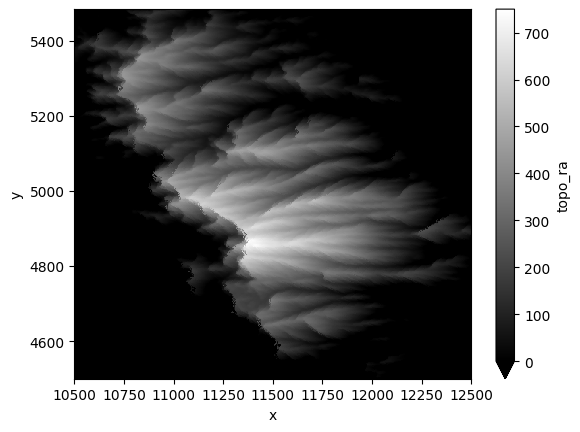

In [155]:
topo.sel(y=slice(4500,5500), x=slice(10500,12500)).plot.imshow(cmap='gray', vmin=0, vmax=750)

In [156]:
import dask
from pygmtsar import tqdm_dask
delayed = sbas.topo_ra(interactive=False)
tqdm_dask(dask.persist(delayed))
# 398/398 [01:49<00:00, 23.63it/s] 398/398 [01:05<00:00, 13.71it/s] 398/398 [00:59<00:00, 16.60it/s]
# 398/398 [02:44<00:00, 10.80it/s]
# 398/398 [27:28<00:00, 6.15it/s]

  0%|          | 0/9000000.0 [00:00<?, ?it/s]

2023-07-03 23:28:44,487 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.84 GiB -- Worker memory limit: 4.00 GiB


In [26]:
import dask
from pygmtsar import tqdm_dask
delayed = sbas.topo_ra(chunksize=1024, interactive=False)
tqdm_dask(dask.persist(delayed))
# 101/101 [00:28<00:00, 5.11it/s]
# 101/101 [00:45<00:00, 5.81it/s]
# 101/101 [07:14<00:00, 1.36it/s]

  0%|          | 0/9000000.0 [00:00<?, ?it/s]

2023-07-03 22:37:45,249 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-07-03 22:37:51,157 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-07-03 22:37:53,452 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-07-03 22:37:56,025 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2023-07-03 22:37:58,097 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-07-03 22:38:00,175 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-07-03 22:38:02,627 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2023-07-03 22:38:06,132 - distributed.utils_perf - WARNING - full garbage collections took

In [27]:
import dask
from pygmtsar import tqdm_dask
delayed = sbas.topo_ra(chunksize=2048, interactive=False)
tqdm_dask(dask.persist(delayed))
# 38/38 [00:17<00:00, 2.11it/s]
# ...
# 38/38 [02:32<00:00, 1.14s/it]

  0%|          | 0/9000000.0 [00:00<?, ?it/s]

2023-07-03 22:38:21,056 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


In [158]:
topo_ra = sbas.get_topo_ra()
topo_ra

<xarray.DataArray 'topo_ra' (y: 2742, x: 10786)>
dask.array<getitem, shape=(2742, 10786), dtype=float32, chunksize=(512, 512), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) int32 1 3 5 7 9 11 13 ... 21561 21563 21565 21567 21569 21571
  * y        (y) int32 1 3 5 7 9 11 13 15 ... 5471 5473 5475 5477 5479 5481 5483

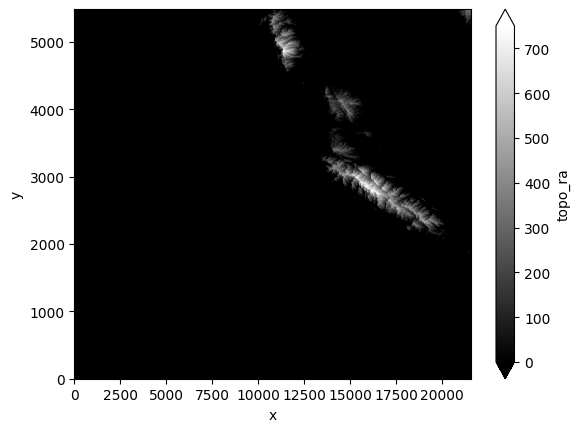

In [160]:
topo_ra.plot.imshow(cmap='gray', vmin=0, vmax=750)